# Analyzing Cricket records from 1971 to 2017

* This dataset was obtained from [here](https://www.kaggle.com/jaykay12/odi-cricket-matches-19712017)
* It consists for 3392 rows and 7 features.
* I will primarily be using the pandas library for data manipulations.
* I will not be delving into model creation here. 
* For data visualizations I will be using matplotlib and seaborn libraries.
* In total I will try to answer 7 questions that I have for the dataset through visualizations.

In [1]:
project_name = "analyzing-cricket-records-from-1971-2017" # change this

In [2]:
#!pip install jovian --upgrade -q

In [3]:
import jovian
import pandas as pd
import numpy as np

In [4]:
# jovian.commit(project=project_name, files = ['originalDataset.csv'])

## Data Preparation and Cleaning

* Read into the dataset and change headings.
* Drop unnecesary columns.
* Creating new columns for day, month, year.
* Creating a new date column with datatype datetime.
* Creating new columns for better understanding of the data.


### Original Dataset

In [5]:
cricket = pd.read_csv('originalDataset.csv',
                      names = ['Match number','Home team',
                               'Away team','Winner','Margin','Ground','date']
                     )
cricket = cricket.iloc[1:]

### Dataset for visualization

In [6]:
df = cricket.copy()
df.drop('Match number',inplace = True, axis = 1)

##### Creating new columns for date

In [7]:
datesplit = [i.split() for i in df['date']]
day = []
month = []
year = []
month_number = [1,8,2,7,9,3,6,12,10,4,5,11]
for i in range(len(datesplit)):
    month.append(datesplit[i][0])
    day.append(datesplit[i][1][:-1])
    year.append(int(datesplit[i][2]))
df['day'] = day
df['month name'] = month
df['month'] = df['month name']
df['month'].replace(df['month name'].unique(),month_number,inplace = True)
df['year'] = year

for i in range(1,len(df['day'])):
    if len(df['day'][i].split('-'))>1:
        df.replace(df['day'][i],df['day'][i].split('-')[0],inplace = True)
    else:
        pass
df['day'] = df['day'].astype('int64')

##### Creating new columns like "won chasing","won at home" etc.

In [8]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df['Margin'].fillna('unknown',inplace = True)
df['won chasing'] = [1 if len(i.split())>1 and i.split()[1] == 'wickets' else 0 for i in df['Margin']]
df['won at home'] = [1 if df['Home team'][i] == df['Winner'][i] else 0 for i in range(1,len(df)+1)]
df['won away'] = [1 if df['Away team'][i] == df['Winner'][i] else 0 for i in range(1,len(df)+1)]


In [9]:
df.head()

,Home team,Away team,Winner,Margin,Ground,date,day,month name,month,year,won chasing,won at home,won away
1,Australia,England,Australia,5 wickets,Melbourne,1971-01-05,5,Jan,1,1971,1,1,0
2,England,Australia,England,6 wickets,Manchester,1972-08-24,24,Aug,8,1972,1,1,0
3,England,Australia,Australia,5 wickets,Lord's,1972-08-26,26,Aug,8,1972,1,0,1
4,England,Australia,England,2 wickets,Birmingham,1972-08-28,28,Aug,8,1972,1,1,0
5,New Zealand,Pakistan,New Zealand,22 runs,Christchurch,1973-02-11,11,Feb,2,1973,0,1,0


### Dataset for model creation

In [10]:
df_1 = df.copy()

In [11]:
inplace = True
df_1.drop(['month name','date','Margin'],axis = 1,inplace = inplace)
df_1.replace(df_1['Ground'].unique(),list(range(len(df_1['Ground'].unique()))),inplace = inplace)

##### Performing one hot encoding on dataset for Winners column

In [12]:
for i in df_1['Winner'].unique():
    x = []
    df_1[i] = 1
    for j in range(1,len(df_1['Winner'])+1):
        if df_1['Winner'][j]==i:
            x.append(1)
        else:
            x.append(0)
    df_1[i] = x
    
df_1.drop(['Home team','Away team','Winner'],axis = 1,inplace = inplace)

### Creating dataset 2 from dataset 1

In [13]:
df['count'] = 1
d = pd.DataFrame(df.Winner.value_counts())
x = d.reset_index()
x.columns = ['Country','Winner']
b = pd.DataFrame(df.groupby('Winner').sum()['won at home'])
y = b.reset_index()
y.columns = ['Country','Won at home']
homevsaway = x.merge(y)
homevsaway['Won away'] = homevsaway['Winner']-homevsaway['Won at home']

In [14]:
away1 = pd.DataFrame(df.groupby('Away team').count()['count'])
home1 = pd.DataFrame(df.groupby('Home team').count()['count'])

In [15]:
f = away1.join(home1,on = 'Away team',lsuffix = ' ')
f = f.reset_index()
f.columns = ['Country','Away total','Home total']
f.fillna(0,inplace = True)

In [16]:
homevsaway = homevsaway.merge(f)
homevsaway.set_index('Country',inplace = True)
homevsaway.fillna(0,inplace = True)
homevsaway['Total matches played'] = homevsaway['Home total'] + homevsaway['Away total']
homevsaway[['Home total','Away total','Total matches played']] = homevsaway[['Home total','Away total','Total matches played']].astype('int64')
homevsaway['Lost at home'] = homevsaway['Home total']-homevsaway['Won at home']
homevsaway['Lost away'] = homevsaway['Away total']-homevsaway['Won away']

In [17]:
homevsaway.columns = ['Total Won','Won at home', 'Won away', 'Away total', 'Home total',
       'Total matches played', 'Lost at home', 'Lost away']

## Now we are ready with 3 dataframes and can use each according to our convenience.

### Original Dataset

In [18]:
cricket.head()

,Match number,Home team,Away team,Winner,Margin,Ground,date
1,ODI # 1,Australia,England,Australia,5 wickets,Melbourne,"Jan 5, 1971"
2,ODI # 2,England,Australia,England,6 wickets,Manchester,"Aug 24, 1972"
3,ODI # 3,England,Australia,Australia,5 wickets,Lord's,"Aug 26, 1972"
4,ODI # 4,England,Australia,England,2 wickets,Birmingham,"Aug 28, 1972"
5,ODI # 5,New Zealand,Pakistan,New Zealand,22 runs,Christchurch,"Feb 11, 1973"


In [19]:
cricket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 1 to 3932
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Match number  3932 non-null   object
 1   Home team     3932 non-null   object
 2   Away team     3932 non-null   object
 3   Winner        3932 non-null   object
 4   Margin        3753 non-null   object
 5   Ground        3932 non-null   object
 6   date          3932 non-null   object
dtypes: object(7)
memory usage: 215.2+ KB


### Modified dataset for visualizations

##### Dataset 1

In [20]:
df.head()

,Home team,Away team,Winner,Margin,Ground,date,day,month name,month,year,won chasing,won at home,won away,count
1,Australia,England,Australia,5 wickets,Melbourne,1971-01-05,5,Jan,1,1971,1,1,0,1
2,England,Australia,England,6 wickets,Manchester,1972-08-24,24,Aug,8,1972,1,1,0,1
3,England,Australia,Australia,5 wickets,Lord's,1972-08-26,26,Aug,8,1972,1,0,1,1
4,England,Australia,England,2 wickets,Birmingham,1972-08-28,28,Aug,8,1972,1,1,0,1
5,New Zealand,Pakistan,New Zealand,22 runs,Christchurch,1973-02-11,11,Feb,2,1973,0,1,0,1


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 1 to 3932
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Home team    3932 non-null   object        
 1   Away team    3932 non-null   object        
 2   Winner       3932 non-null   object        
 3   Margin       3932 non-null   object        
 4   Ground       3932 non-null   object        
 5   date         3932 non-null   datetime64[ns]
 6   day          3932 non-null   int64         
 7   month name   3932 non-null   object        
 8   month        3932 non-null   int64         
 9   year         3932 non-null   int64         
 10  won chasing  3932 non-null   int64         
 11  won at home  3932 non-null   int64         
 12  won away     3932 non-null   int64         
 13  count        3932 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(6)
memory usage: 430.2+ KB


##### Dataset 2

In [22]:
homevsaway.head()

,Total Won,Won at home,Won away,Away total,Home total,Total matches played,Lost at home,Lost away
Country,,,,,,,,
Australia,555,383,172,323,583,906,200,151
India,476,315,161,368,562,930,247,207
Pakistan,469,224,245,502,382,884,158,257
West Indies,380,141,239,507,260,767,119,268
Sri Lanka,372,172,200,508,300,808,128,308


In [23]:
homevsaway.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, Australia to ICC World XI
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Total Won             22 non-null     int64
 1   Won at home           22 non-null     int64
 2   Won away              22 non-null     int64
 3   Away total            22 non-null     int64
 4   Home total            22 non-null     int64
 5   Total matches played  22 non-null     int64
 6   Lost at home          22 non-null     int64
 7   Lost away             22 non-null     int64
dtypes: int64(8)
memory usage: 1.5+ KB


### Dataframe for model creation

In [24]:
df_1.head()

,Ground,day,month,year,won chasing,won at home,won away,Australia,England,New Zealand,...,Netherlands,ICC World XI,Africa XI,Asia XI,Bermuda,Ireland,Scotland,Afghanistan,P.N.G.,Hong Kong
1,0,5,1,1971,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,24,8,1972,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,26,8,1972,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,28,8,1972,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,4,11,2,1973,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 1 to 3932
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Ground        3932 non-null   int64
 1   day           3932 non-null   int64
 2   month         3932 non-null   int64
 3   year          3932 non-null   int64
 4   won chasing   3932 non-null   int64
 5   won at home   3932 non-null   int64
 6   won away      3932 non-null   int64
 7   Australia     3932 non-null   int64
 8   England       3932 non-null   int64
 9   New Zealand   3932 non-null   int64
 10  no result     3932 non-null   int64
 11  West Indies   3932 non-null   int64
 12  Pakistan      3932 non-null   int64
 13  India         3932 non-null   int64
 14  Sri Lanka     3932 non-null   int64
 15  Zimbabwe      3932 non-null   int64
 16  tied          3932 non-null   int64
 17  South Africa  3932 non-null   int64
 18  Kenya         3932 non-null   int64
 19  U.A.E.        3932 non-null

In [26]:
#import jovian

In [27]:
# jovian.commit()

## Exploratory Analysis and Visualization

* Describe the original dataset first.
* Create bar graph for total matches won by country.
* Create a stacked bar chart to see home and away wins by country.
* Create a horizontal bar chart to see the top 20 grounds that have hosted the most number of matches.
* Look at the trend of number of matches played by year using a line chart.
* Let us look at the correlation between wins/losses home and away against total matches played for all teams using a scatter plot.
* Group by Country and ground to check where a teams wins most.
* Create wordclouds for above point.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\tejas\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [29]:
cricket.describe()

,Match number,Home team,Away team,Winner,Margin,Ground,date
count,3932,3932,3932,3932,3753,3932,3932
unique,3932,24,25,25,227,173,3386
top,ODI # 2781,Australia,Sri Lanka,Australia,6 wickets,Sharjah,"Feb 4, 2007"
freq,1,583,508,555,347,228,6


Describing the dataset already provides some relevant insights. 

* We see Australia winning the most number of matches in this dataset.
* We also see the most number of times a team has won chasing has done so with a margin of 6 wickets although we see there are missing values in this dataset for this column so this should not be considered.
* Most number of matches have been held in Sharjah in this dataset.
* Sri Lanka has toured for matches the most number of times.

**These are some initial inferences that I have made lets see after data manipulations how many of these inferences were accurate?**

In [30]:
homevsaway

,Total Won,Won at home,Won away,Away total,Home total,Total matches played,Lost at home,Lost away
Country,,,,,,,,
Australia,555,383,172,323,583,906,200,151
India,476,315,161,368,562,930,247,207
Pakistan,469,224,245,502,382,884,158,257
West Indies,380,141,239,507,260,767,119,268
Sri Lanka,372,172,200,508,300,808,128,308
South Africa,361,194,167,304,279,583,85,137
England,343,221,122,304,393,697,172,182
New Zealand,324,207,117,339,392,731,185,222
Zimbabwe,129,58,71,295,196,491,138,224


### Bar graph for number of matches won by each team

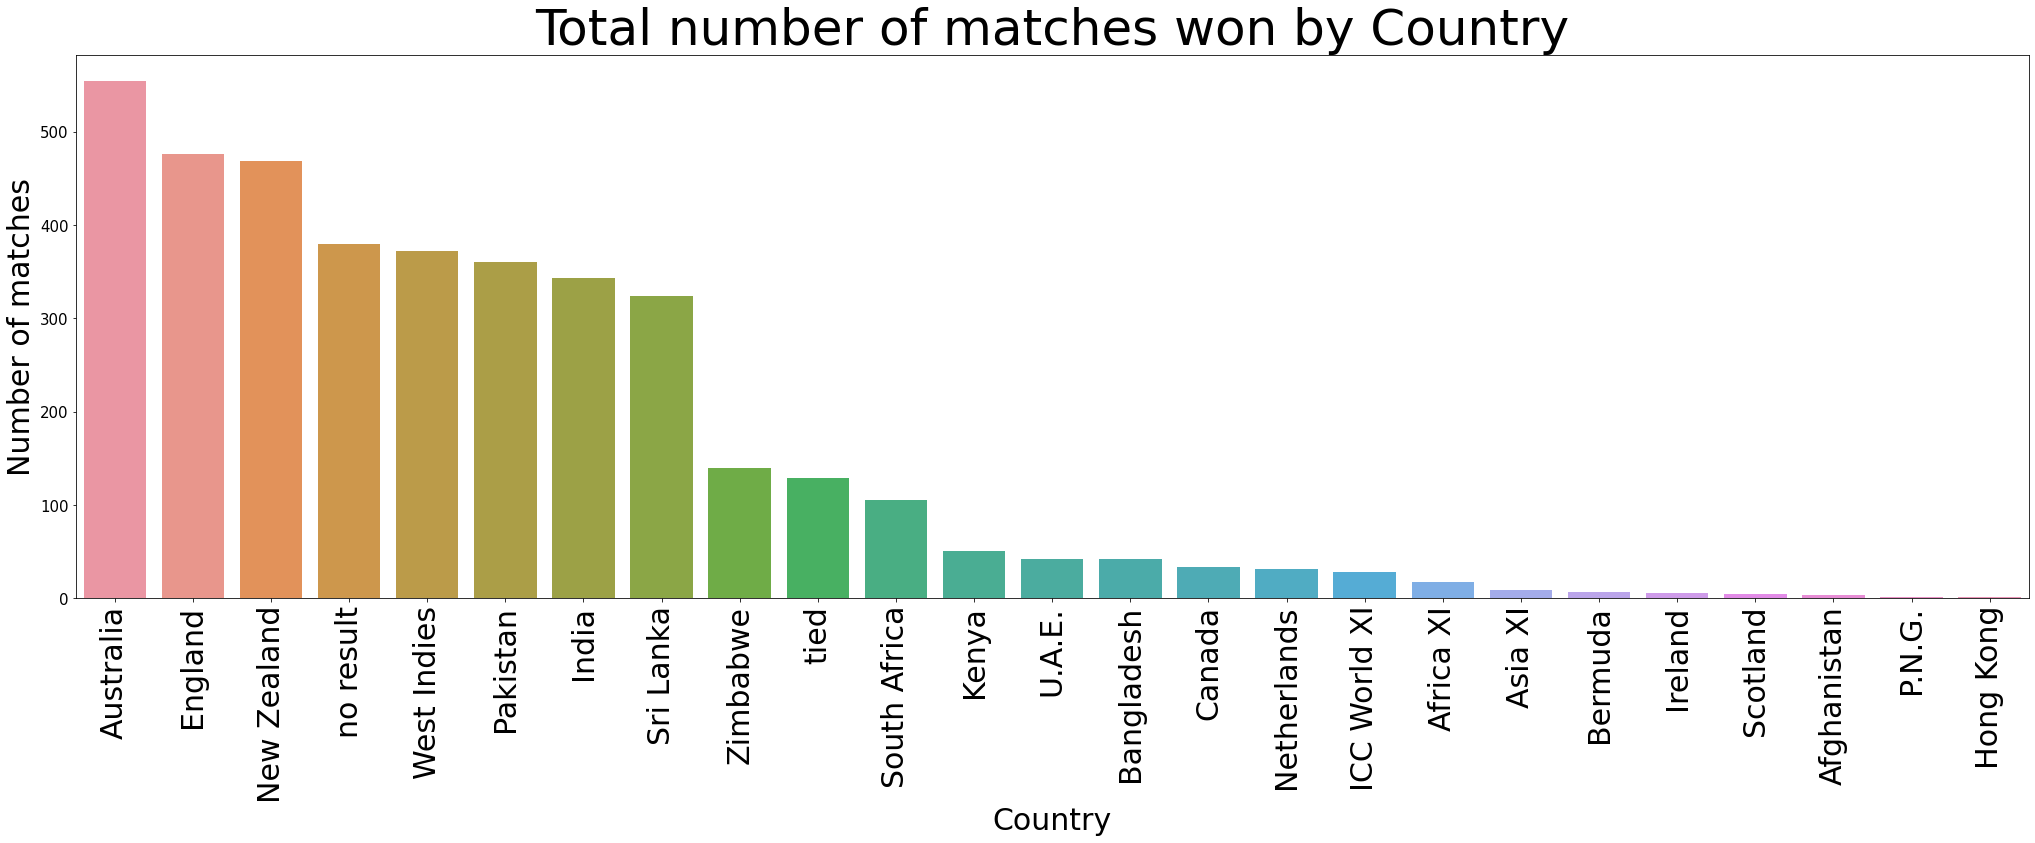

In [31]:
plt.figure(figsize  = (35,10))
sns.barplot(x =df['Winner'].unique(), y = df.Winner.value_counts())
plt.xticks(rotation = 90,fontsize = 30)
plt.yticks(fontsize = 15)
plt.ylabel('Number of matches',{'fontsize': 30})
plt.xlabel('Country',{'fontsize': 30})
plt.title('Total number of matches won by Country',{'fontsize': 50})
plt.show()

### Bar graph for number of matches won by each team at home and away

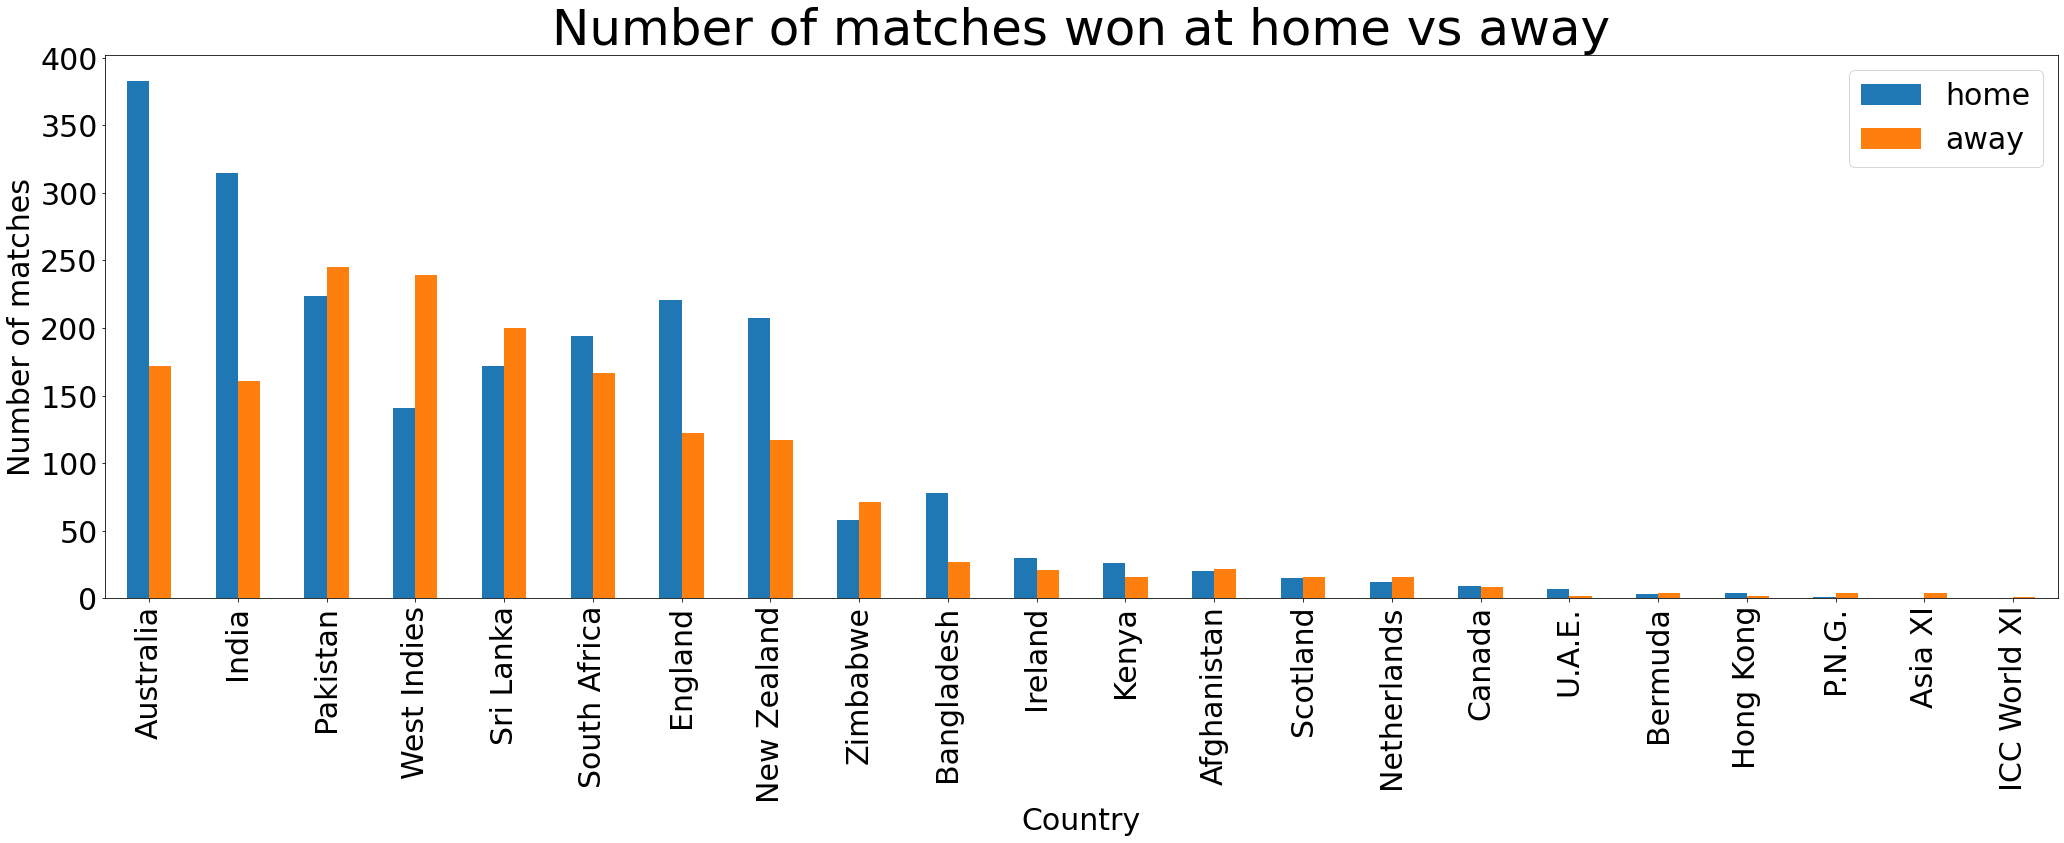

In [32]:
homevsaway[['Won at home','Won away']].plot.bar(rot=0, figsize = (35,10))
plt.xticks(rotation = 90,fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(['home','away'],fontsize= 30)
plt.title('Number of matches won at home vs away',{'fontsize':50})
plt.ylabel('Number of matches',{'fontsize': 30})
plt.xlabel('Country',{'fontsize': 30})
plt.show()

### Top 20 highest number of matches played by ground

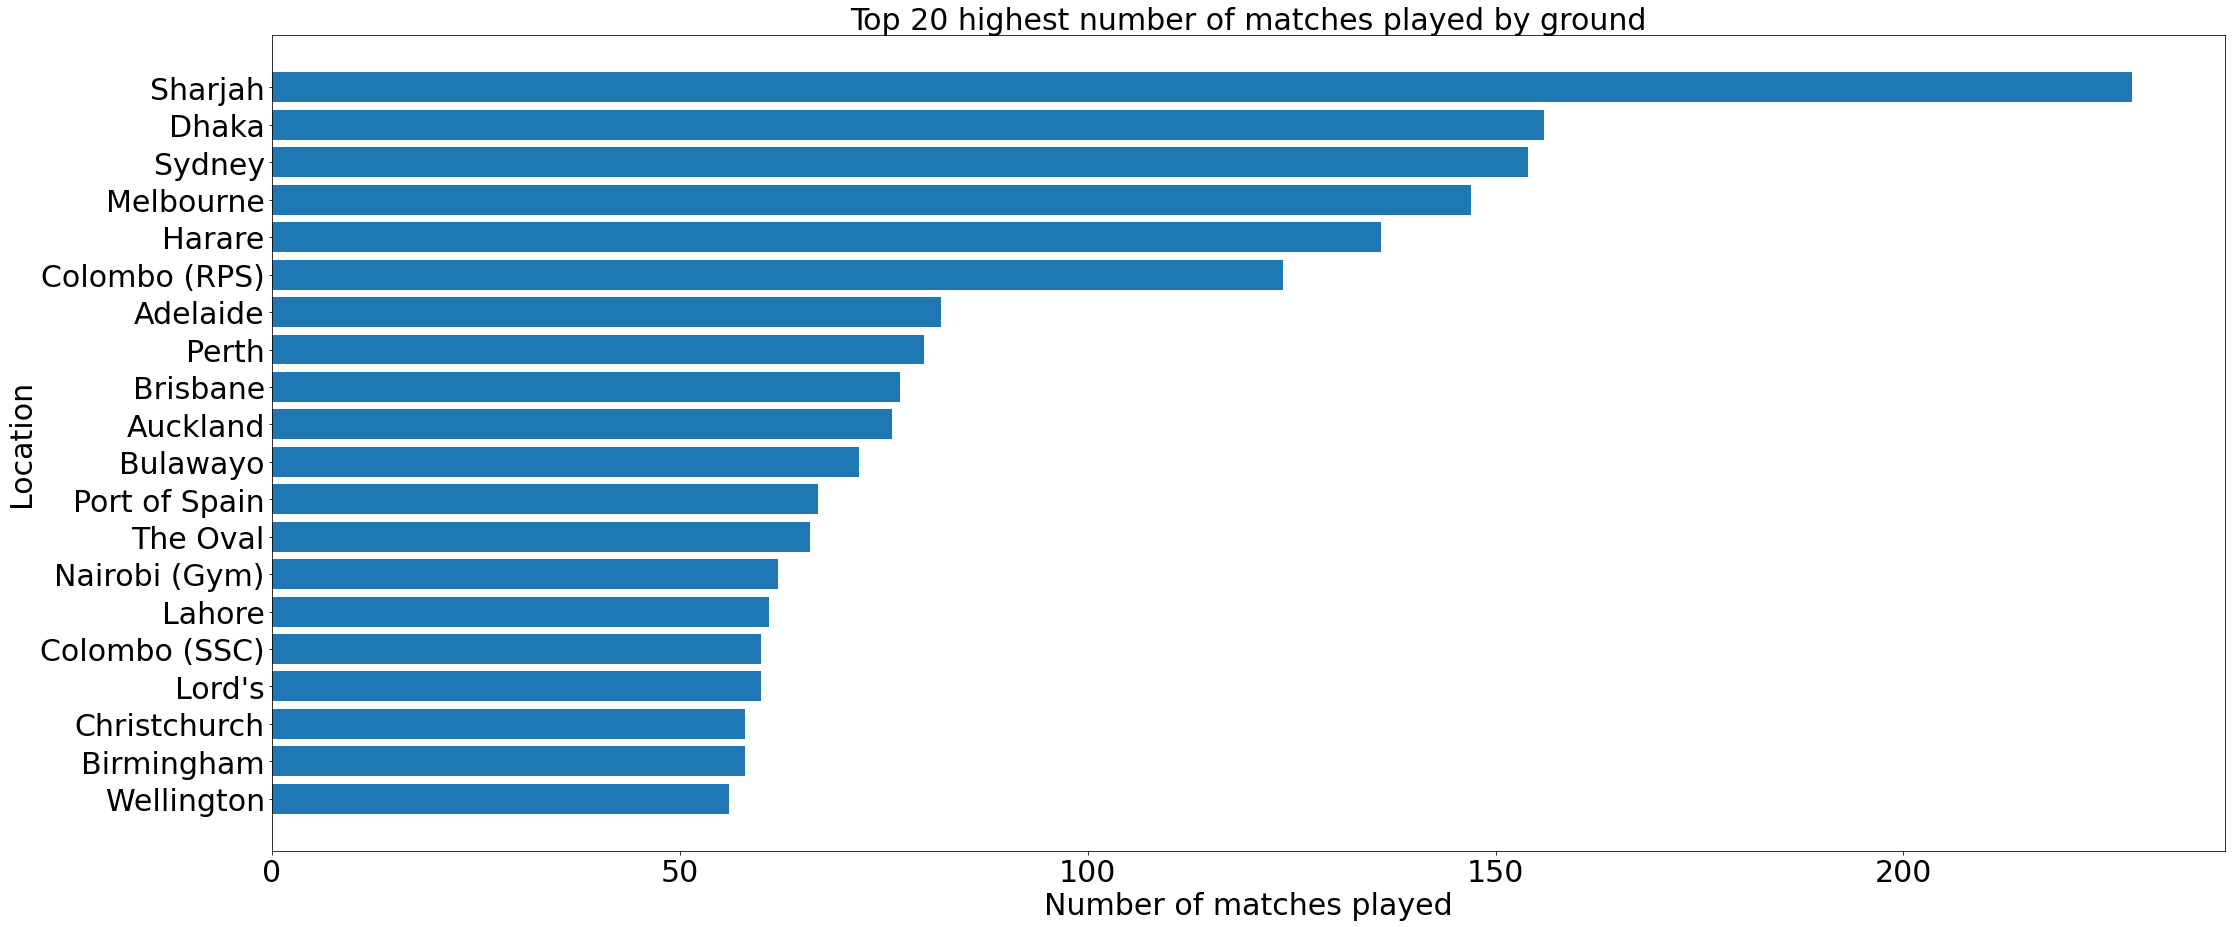

In [33]:
g = pd.DataFrame(df.groupby('Ground').count()['count'])
g.sort_values('count',ascending = False,inplace = True)
g.columns = ['Matches played']
g = g.reset_index()
g = g.head(20)
g.sort_values('Matches played',inplace = True)
plt.figure(figsize = (35,15))
plt.barh(g['Ground'],g['Matches played'])
x = plt.yticks(fontsize = 30)
x = plt.xticks(fontsize = 30)
plt.xlabel('Number of matches played',fontsize = 30)
plt.ylabel('Location',fontsize = 30)
plt.title('Top 20 highest number of matches played by ground',fontsize = 30)
plt.show()

### Looking at the number of matches each team won batting first and chasing

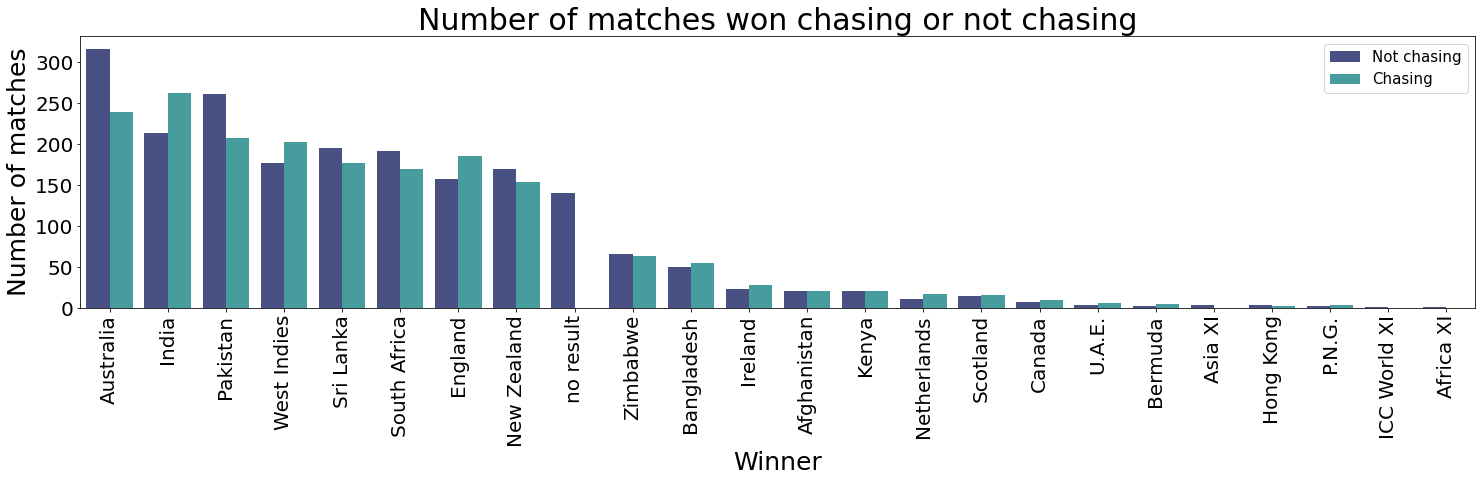

In [34]:
c = df.groupby(['Winner','won chasing']).count()['count'].reset_index()
c = c[:-1].sort_values('count',ascending = False)
c['won chasing'].replace([0,1],['Not chasing','Chasing'],inplace = True)
plt.figure(figsize = (25,5))
plotc = sns.barplot(x = 'Winner',y = 'count',hue = 'won chasing',data = c,palette = 'mako')
plotc.legend(loc = 'upper right',fontsize = 15)
plt.title('Number of matches won chasing or not chasing',fontsize = 30)
plt.xticks(rotation = 90,fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('Winner',fontsize =  25)
plt.ylabel('Number of matches',fontsize =  25)
plt.show()

### Trend of matches played by year

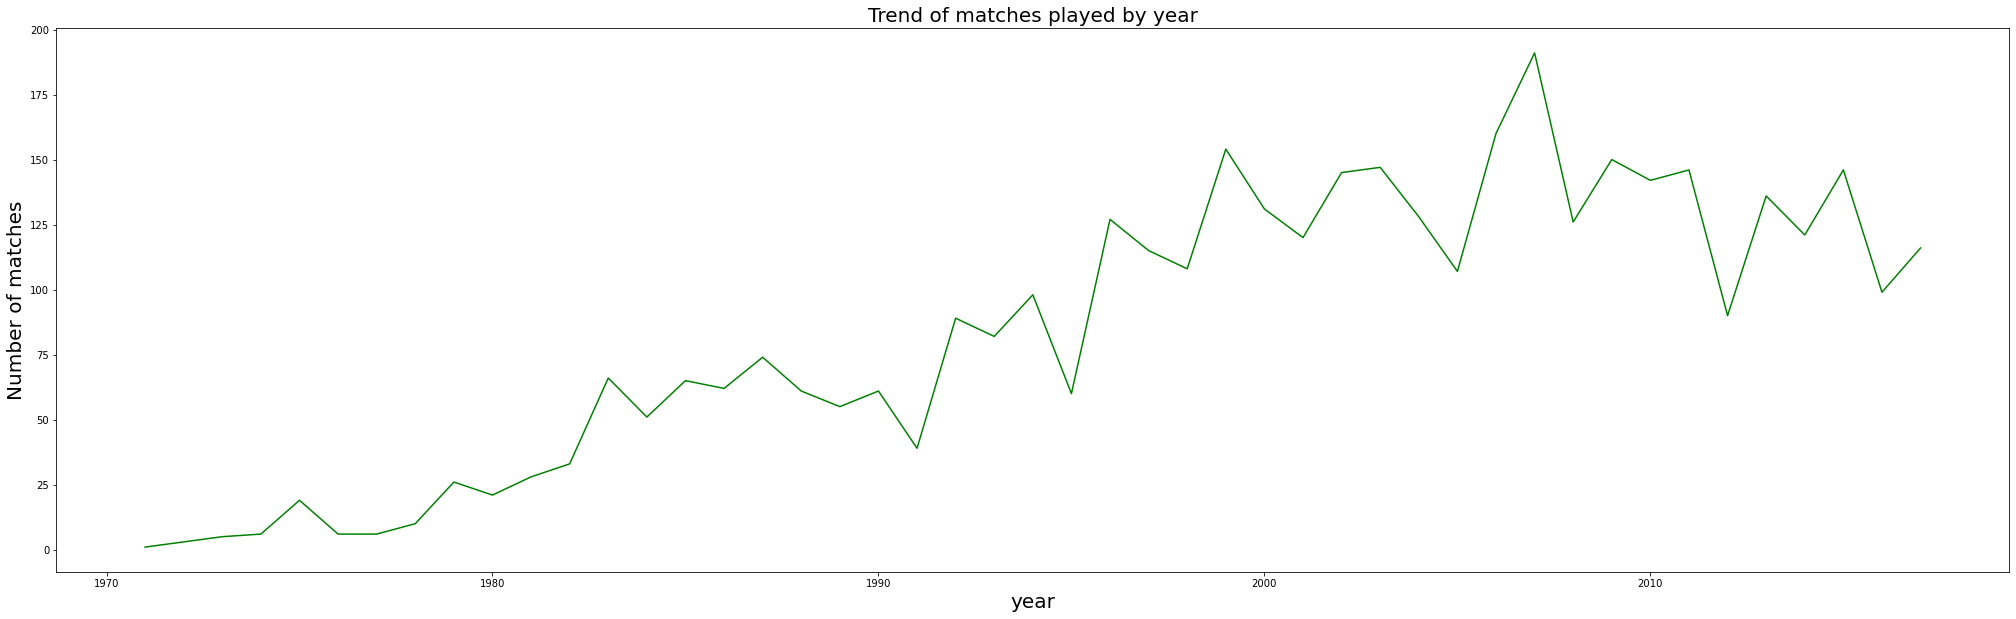

In [35]:
fig = plt.figure(figsize=(35,10))
plt.plot(df.groupby('year').count()['count'],color = 'green')
plt.title('Trend of matches played by year',fontsize = 20)
plt.xlabel('year',fontsize = 20)
plt.ylabel('Number of matches',fontsize = 20)
plt.show()

### Number of matches played by year

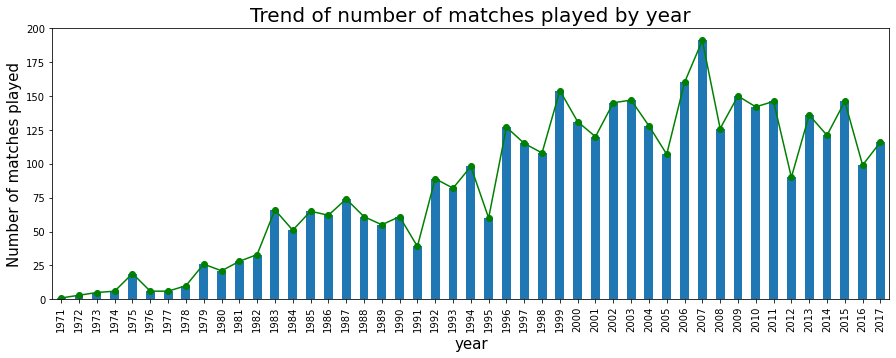

In [36]:
data = pd.DataFrame(df.groupby('year').count()['count']).reset_index()

ax = data.plot(x = 'year',marker = 'o',use_index = False,color = 'green',legend = False)
data.plot(x = 'year',kind = 'bar',ax=ax,figsize = (15,5),legend = False)
plt.title('Trend of number of matches played by year',fontsize = 20)
x = plt.yticks(fontsize = 10)
x = plt.xticks(fontsize = 10)
plt.xlabel('year',fontsize = 15)
plt.ylabel('Number of matches played',fontsize = 15)
plt.show()

### Correlation between total matches and matches won at home 

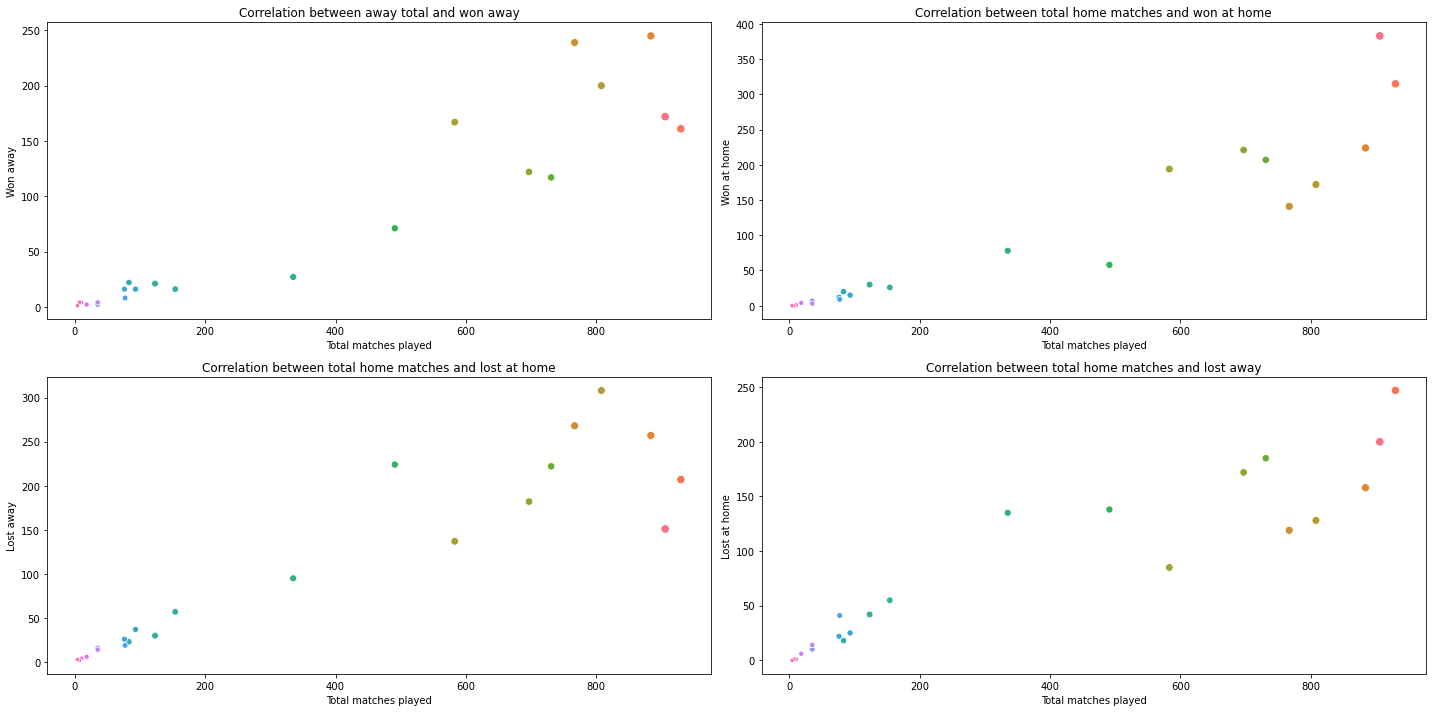

In [37]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
plt.title('Correlation between away total and won away')
sns.scatterplot(x = 'Total matches played',y = 'Won away',hue = 'Country',data = homevsaway.reset_index(),size = 'Country', legend = None)
plt.subplot(2,2,2)
plt.title('Correlation between total home matches and won at home')
sns.scatterplot(x = 'Total matches played',y = 'Won at home',hue = 'Country',data = homevsaway.reset_index(),size = 'Country',legend = None)

plt.subplot(2,2,3)
plt.title('Correlation between total home matches and lost at home')
sns.scatterplot(x = 'Total matches played',y = 'Lost away',hue = 'Country',data = homevsaway.reset_index(),size = 'Country',legend = None)
plt.subplot(2,2,4)
plt.title('Correlation between total home matches and lost away')
sns.scatterplot(x = 'Total matches played',y = 'Lost at home',hue = 'Country',data = homevsaway.reset_index(),size = 'Country',legend = None)
plt.tight_layout()

plt.show()

Since all the above graphs are somewhat linear, we can say that there is no difference in relation between home and away match wins. We can conclude that the more a team plays the higher their wins and losses so there is no significant impact these variables create. The relationship is linear in all cases which means there is a positive correlation with the total matches played.

### Which ground was most lucky for which team at home and away?

In [38]:
luckygroundh = df[df['won at home'] == 1]
luckygroundh = luckygroundh[luckygroundh['Ground']!='Sharjah']
luckygroundh.head()
luckygrounda = df[df['won away'] == 1]
luckygrounda.head()

lh = luckygroundh.groupby('Winner')['Ground'].value_counts(ascending = False)
gh = pd.DataFrame(lh.groupby(level = 0).head(1).sort_values(ascending = False))
gh.columns = ['home wins']
gh = gh.reset_index()
gh.columns = ['Winner', 'Home Ground', 'Home wins']


l = luckygrounda.groupby('Winner')['Ground'].value_counts(ascending = False)
ga = pd.DataFrame(l.groupby(level = 0).head(1).sort_values(ascending = False))
ga.columns = ['away wins']
ga = ga.reset_index()
ga.columns = ['Winner', 'Away Ground', 'Away wins']
combined = gh.merge(ga)
combined

,Winner,Home Ground,Home wins,Away Ground,Away wins
0,Australia,Sydney,85,Auckland,11
1,Sri Lanka,Colombo (RPS),64,Sharjah,20
2,Bangladesh,Dhaka,42,Bulawayo,7
3,Zimbabwe,Harare,38,Dhaka,12
4,New Zealand,Auckland,34,Harare,9
5,Pakistan,Lahore,31,Sharjah,38
6,South Africa,Cape Town,28,Harare,10
7,West Indies,Port of Spain,27,Sharjah,19
8,England,The Oval,27,Sydney,11
9,India,Bengaluru,13,Colombo (RPS),17


There is a problem with Sharjah as a ground mentioned for home and away. I feel Sharjah has usually been a neutral venue since it is located in Dubai. In the dataset under home team India has been mentioned many times when playing against other overseas teams. Hence I have not considered Sharjah as a home venue for any of the teams.

### Most lucky home grounds

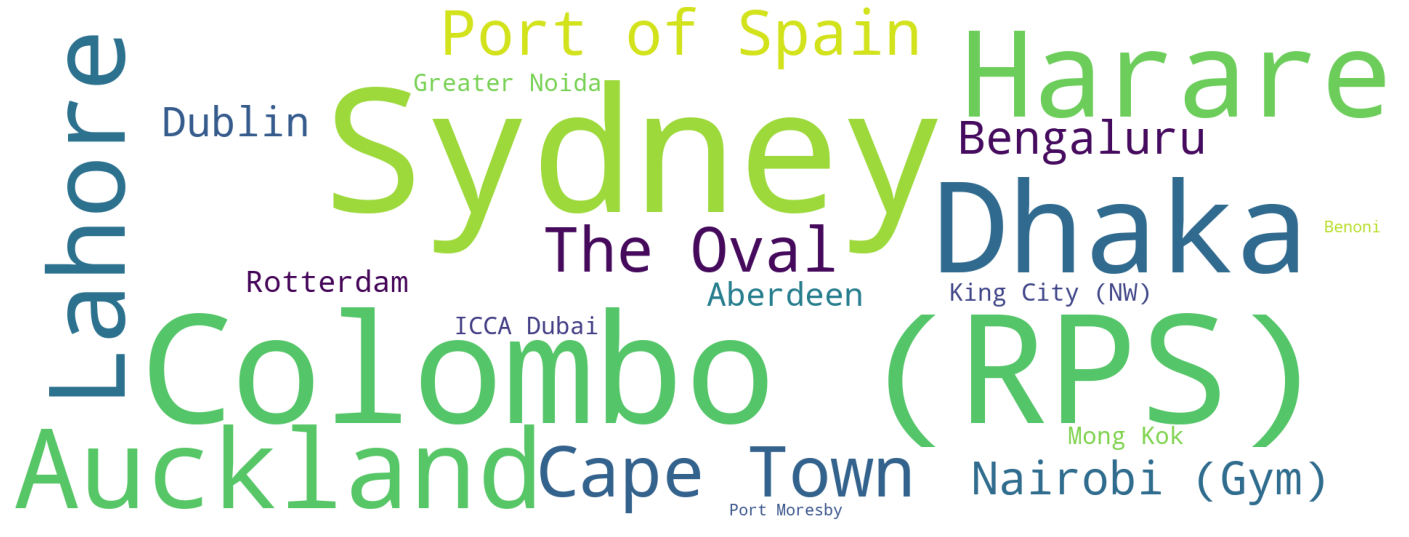

In [39]:
from wordcloud import WordCloud
d = dict(zip(combined['Home Ground'],combined['Home wins']))
plt.figure(figsize = (25,15))
wordcloud = WordCloud(height = 720,width = 1920,background_color = 'white').generate_from_frequencies(d)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Most unlucky home grounds

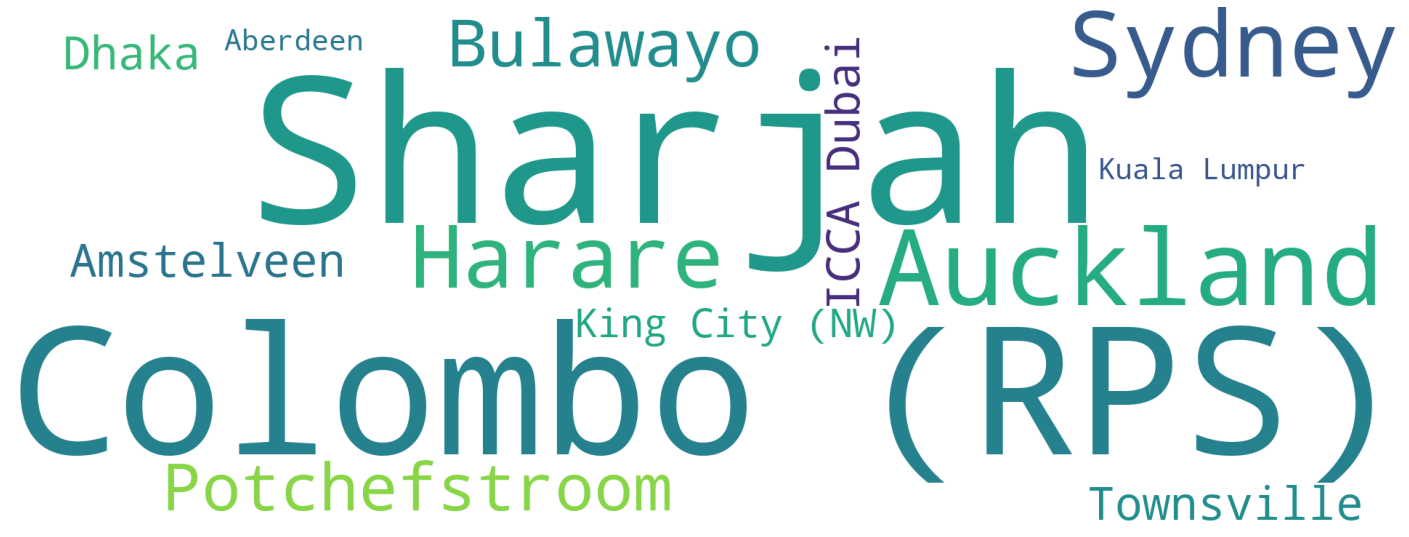

In [40]:
from wordcloud import WordCloud
e = dict(zip(combined['Away Ground'],combined['Away wins']))
plt.figure(figsize = (25,15))
wordcloud = WordCloud(height = 720,width = 1920,background_color = 'white').generate_from_frequencies(e)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [41]:
#import jovian

In [42]:
#jovian.commit()

## Asking and Answering Questions

* How many total matches have been played till 2017?
* Who has won the maximum number of matches (Home and Away)?
* Do teams have a home field advantage?
* Which date has seen the maximum number of matches till 2017?
* Is a team more likely to win chasing or batting first?
* Which ground location is lucky for each team?
* Which grounds have seen the most number of matches?

## 1. How many total matches have been played till 2017?

* As per these records there have been a total of 3932 matches that have been played from 1971 to 2017

## 2. Who has won the maximum number of matches (Home and Away)?

* Home: Australia
* Away: Pakistan

## 3. Do teams have a home field advantage?

##### This is subject to each team

* Teams that play better at home: 
    1. India
    2. Australia
    3. New Zealand
    4. South Africa
    5. England
    6. Bangladesh
    
    
* Teams that play better away: 
    1. Pakistan
    2. West Indies
    3. Sri Lanka
    4. Zimbabwe
    
This is what the graph shows. However if we consider the number of matches played home and away the teams that play better away have played many more matches Away too as compared to home games. 

### Most unlucky home grounds

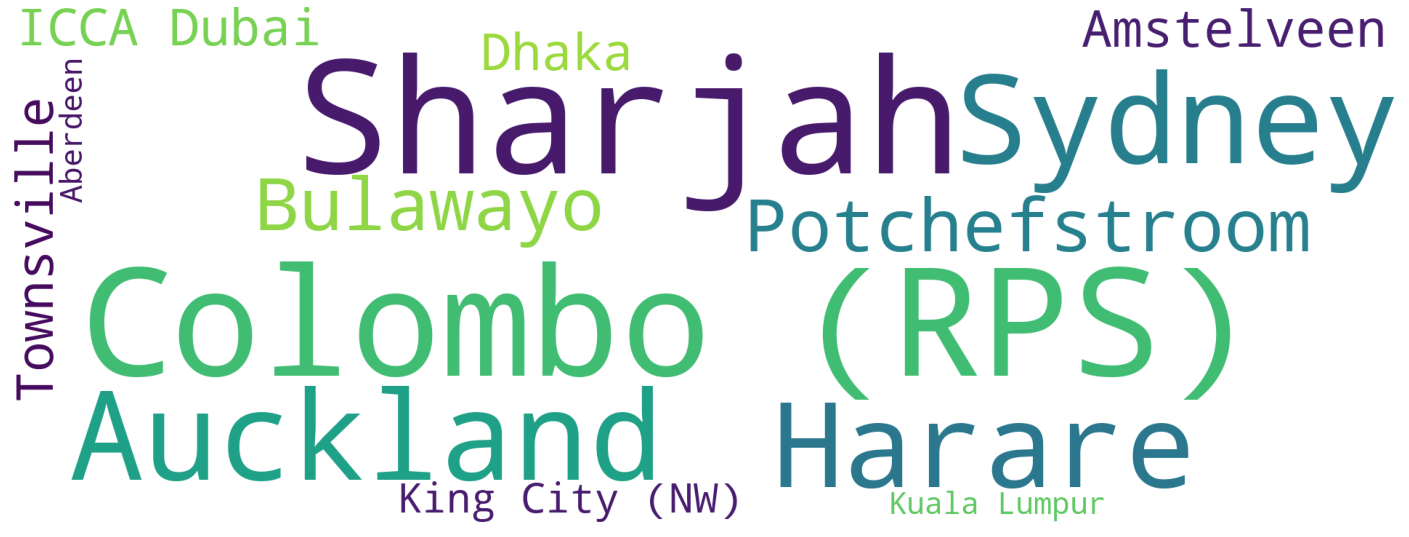

In [43]:
from wordcloud import WordCloud
e = dict(zip(combined['Away Ground'],combined['Away wins']))
plt.figure(figsize = (25,15))
wordcloud = WordCloud(height = 720,width = 1920,background_color = 'white').generate_from_frequencies(e)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

* If we look at the above word cloud we see Colombo is a stadium which hasn't been very lucky for Sri Lanka.
* Pakistan has played a lot of games in Sharjah and cricket records have considered Pakistan as a home and away team. Pakistan has had the most number of wins and losses at Sharjah.
* Sydney comes up in the luckiest ground for Australia and the unluckiest ground for England when playing away.

## 4. Which date has seen the maximum number of matches till 2017?

* 2007 saw the maximum number of matches played since 1971 till 2017 and 1971 saw the least number of games.
* The same graph also shows a trend of increasing number of matches till 2007 after which we have seen a dip in the number of matches played.

## 5. Is a team more likely to win chasing or batting first?

* Teams that play better chasing:

    1. India
    2. West Indies
    3. England
    4. Bangladesh
    5. Ireland

* Teams that play better batting first:

    1. Australia
    2. Pakistan
    3. Sri Lanka
    4. South Africa
    5. New Zealand
    
    
* An interesting observation here is that most top teams play better batting first rather than chasing but we cannot completely conclude that for all teams batting first or chasing would give all teams a win.

## 6. Which ground location is lucky for each team home and away?

* Below we will only look at the top 10 teams and how their most lucky grounds home and away.
* Sharjah will often show up for away teams since Sharjah as a venue was considered home for Pakistan and India while playing vs other teams.

In [44]:
combined.columns = ['Country', 'Home Ground', 'Home wins', 'Away Ground', 'Away wins']
combined.head(11)

,Country,Home Ground,Home wins,Away Ground,Away wins
0,Australia,Sydney,85,Auckland,11
1,Sri Lanka,Colombo (RPS),64,Sharjah,20
2,Bangladesh,Dhaka,42,Bulawayo,7
3,Zimbabwe,Harare,38,Dhaka,12
4,New Zealand,Auckland,34,Harare,9
5,Pakistan,Lahore,31,Sharjah,38
6,South Africa,Cape Town,28,Harare,10
7,West Indies,Port of Spain,27,Sharjah,19
8,England,The Oval,27,Sydney,11
9,India,Bengaluru,13,Colombo (RPS),17


### 7. Which grounds have seen the most number of matches?

* Sharjah has seen the most number of matches played in our dataset followed by Dhaka.
* Top 20 grounds that have seen max number of matches has been graphed above under the EDA section.

In [45]:
#import jovian

In [46]:
#jovian.commit()

## Inferences and Conclusion


    Write a summary of what you've learned from the analysis
    Include interesting insights and graphs from previous sections
    Share ideas for future work on the same topic using other relevant datasets
    Share links to resources you found useful during your analysis


* This analysis gave me answers to some interesting questions that I had about cricket matches.
* Learnt some interesing ways to plot graphs. For example, before I did not know how to plot stacked charts in pandas. Now I was able to create staked bar and stacked bar-line charts.
* Since the dataset is only till 2017, I feel the analysis could become more current if we could get the same records till date.
* For future work I would say we could dive down into each teams stats and performance. I believe this is what the analysts within these teams do today.
* We could also analyze each player and let them know their strengths and weeknesses.
* Data can be extremely powerful in the world of sports. 

### Some insights

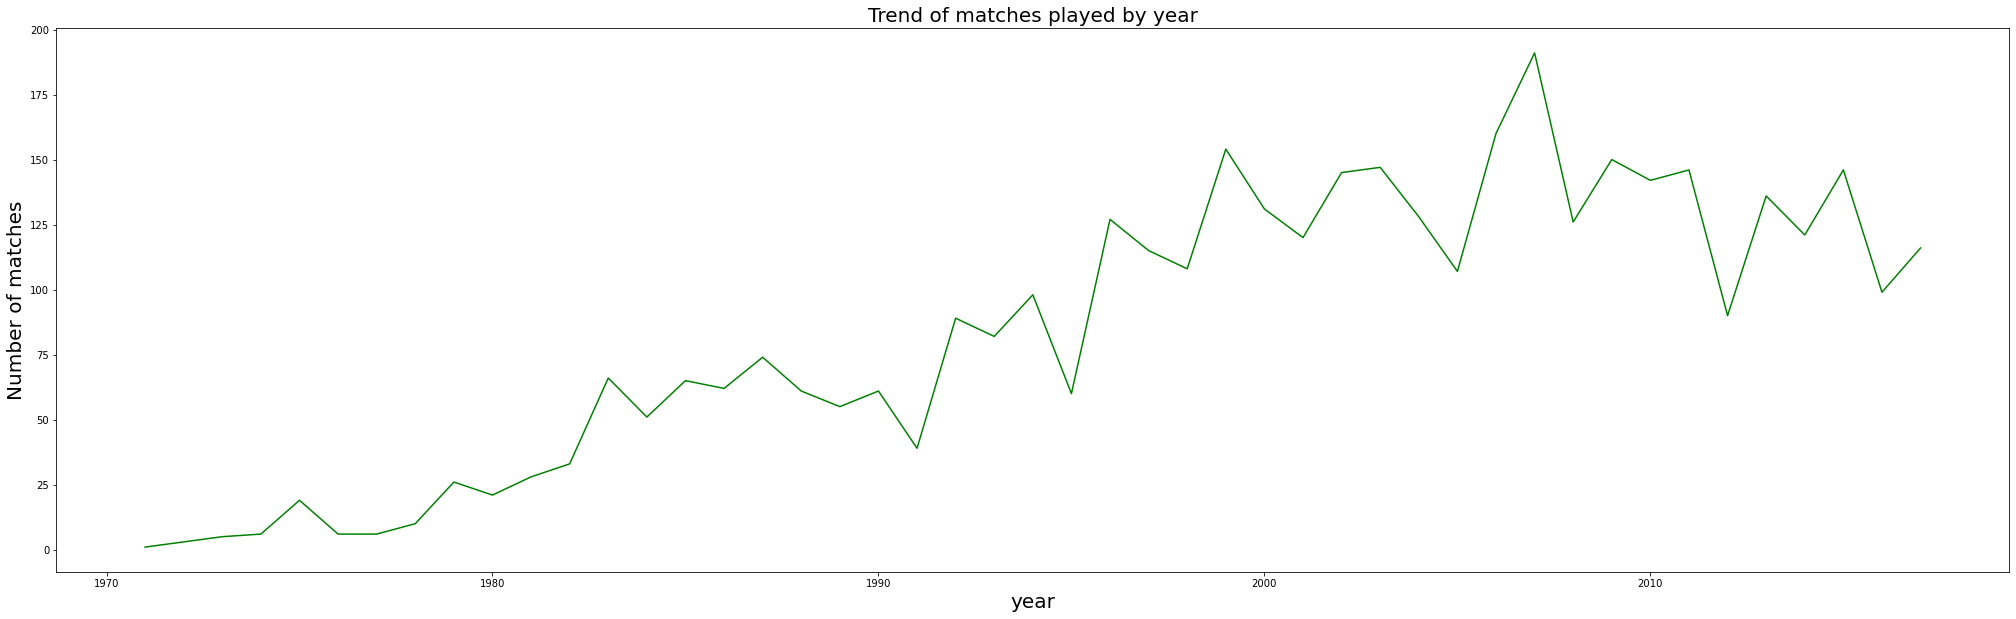

In [47]:
fig = plt.figure(figsize=(35,10))
plt.plot(df.groupby('year').count()['count'],color = 'green')
plt.title('Trend of matches played by year',fontsize = 20)
plt.xlabel('year',fontsize = 20)
plt.ylabel('Number of matches',fontsize = 20)
plt.show()

My expectation for this graph was that it would be a smoother line. Now there are several environmental factors that have taken place across the years that could explain these sudden dips in number of matches played. This is something that can be looked at in depth to prevent such dips in the future. The strange part about this dataset is that we have seen a continuous rise in matches from 1970 till 2007. After this there have only been dips in number of matches. The curve seems to be flattening. This must also be looked at.

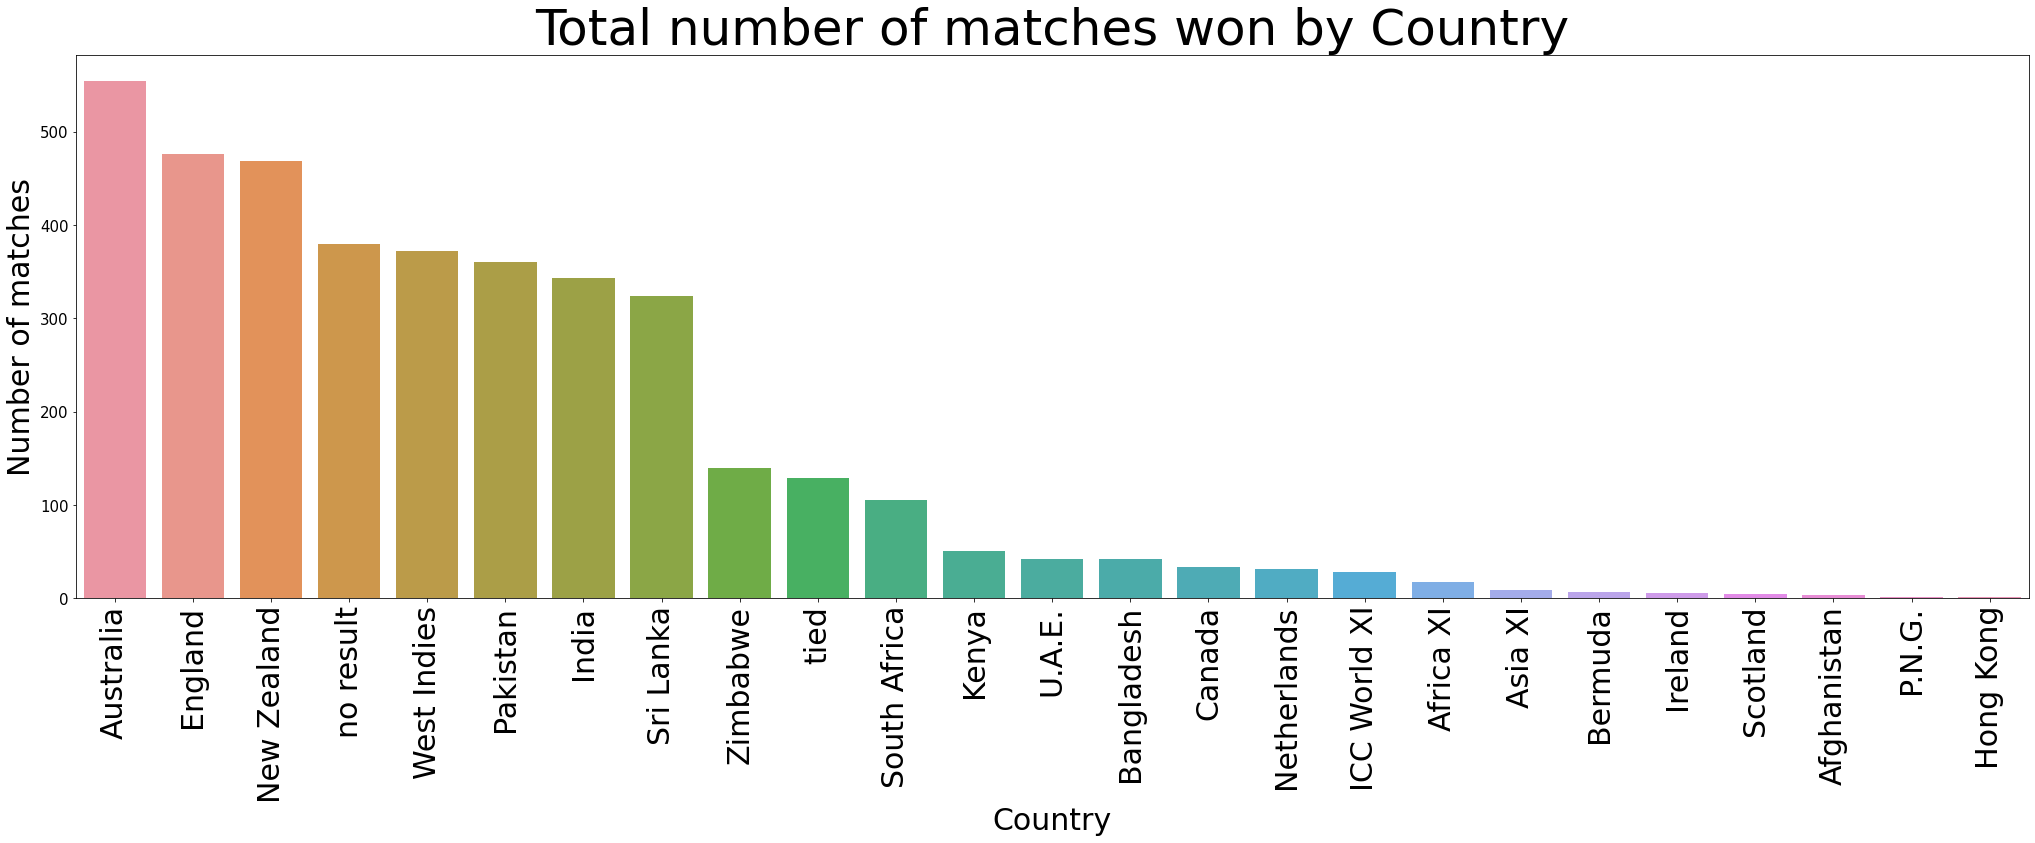

In [48]:
plt.figure(figsize  = (35,10))
sns.barplot(x =df['Winner'].unique(), y = df.Winner.value_counts())
plt.xticks(rotation = 90,fontsize = 30)
plt.yticks(fontsize = 15)
plt.ylabel('Number of matches',{'fontsize': 30})
plt.xlabel('Country',{'fontsize': 30})
plt.title('Total number of matches won by Country',{'fontsize': 50})
plt.show()

* In this graph we can see that there have been many number of matches that have had no result. This primarily was due to weather conditions. 
* In cricket, the game is stopped whenever it rains so many a times it has rained the entire day and caused the match to be abandoned. 
* Now to prevent this ICC had tried to host matches in stadiums with retractable roofs. 
* The first series played under a roof was in 2000 between South Africa and Australia. You can read more about the series [here](https://www.cricketcountry.com/articles/when-cricket-was-played-indoors-for-the-first-time-29991). 
* After which a 3 match series was played between Australia and World XI in 2005 at the Docklands stadium which saw the roof in action. 

##### Why are other stadiums not incorporating a retractable roof?

* Cost seems to be a significant factor as to why most stadiums are not installing this system. 
* Affects the grass in the stadium. 
* The ball also stops swinging making it more batter friendly. 
* Overall it doesn't seem to be feasable to install such a roof.

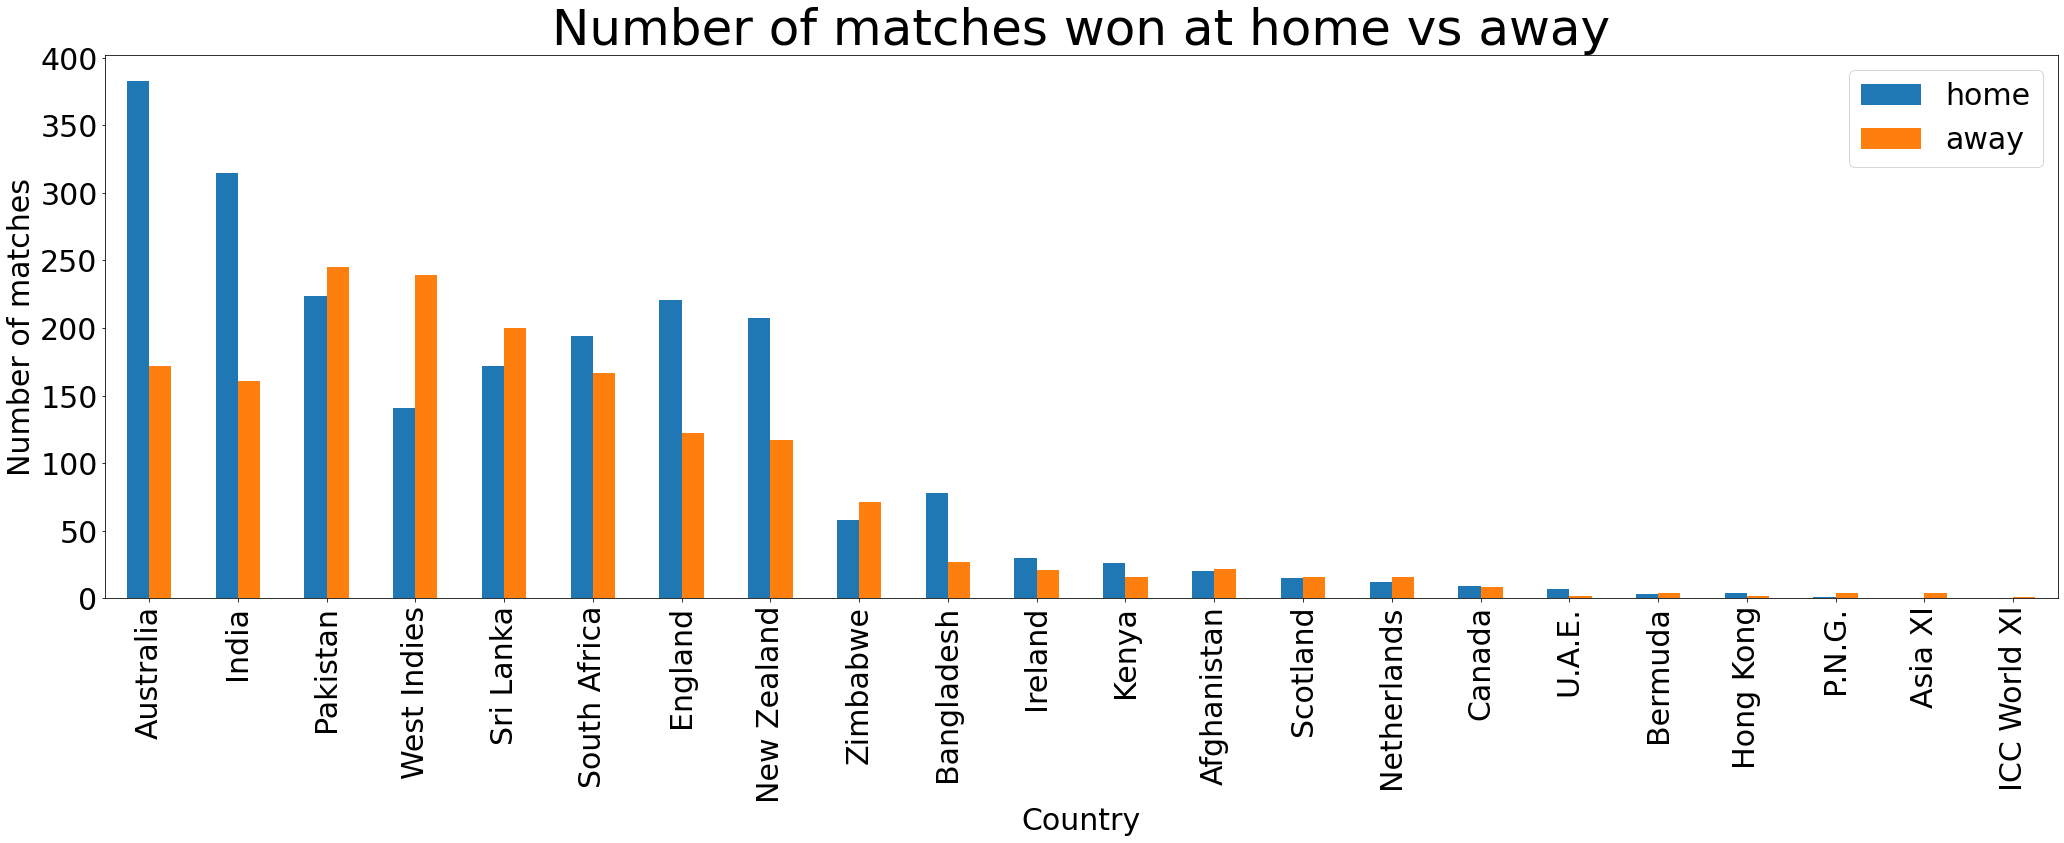

In [49]:
homevsaway[['Won at home','Won away']].plot.bar(rot=0, figsize = (35,10))
plt.xticks(rotation = 90,fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(['home','away'],fontsize= 30)
plt.title('Number of matches won at home vs away',{'fontsize':50})
plt.ylabel('Number of matches',{'fontsize': 30})
plt.xlabel('Country',{'fontsize': 30})
plt.show()

In [50]:
homevsaway.loc[['Pakistan','West Indies','Sri Lanka','Zimbabwe'],['Away total','Home total']]

,Away total,Home total
Country,,
Pakistan,502,382
West Indies,507,260
Sri Lanka,508,300
Zimbabwe,295,196


Being from India, I always thought that all teams play their best cricket at home. But this graph shows a bit of a different picture. Now teams like Pakistan, West Indies and even Sri Lanka seem to be doing better overseas than in their own country. But if we look closely at the Number of Away matches played(Away total) vs Home total, we see that these teams have played far more matches in other coutries than at home. This could explain the anomaly in the graph.

In [51]:
#import jovian

In [52]:
#jovian.commit()

## References and Future Work

##### References
* https://pandas.pydata.org/docs/
* https://matplotlib.org/contents
* https://seaborn.pydata.org/
* https://www.kaggle.com/jaykay12/odi-cricket-matches-19712017

##### Future Work

* There is a lot more that can be analyzed from this dataset.
* Analysis can be done for each player, team, bowler etc. to get an overall idea of what impacts results in a match.
* I have found out about stadiums that have been lucky for a certain team. We could look at why this is the case. Was it the players or the stadium iteself.
* There is also a lot of scope in analyzing the impact technology has had on the game. Which teams have benefited from technology the most.
* A lot of data that will be generated now in 2020 will be much more useful for future games since COVID-19 has had a major impact across the world. 

#### Thank you for going through my notebook. If you have read till here, you could send me a message on [twitter @tejasmayyar](https://twitter.com/tejasmayyar) letting me know about what you thought about my notebook.

In [53]:
#import jovian

In [55]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "tejasmohan01/analyzing-cricket-records-from-1971-2017" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ml/tejasmohan01/analyzing-cricket-records-from-1971-2017


'https://jovian.ml/tejasmohan01/analyzing-cricket-records-from-1971-2017'